In [24]:
import cv2

import tensorflow as tf
import os
import random
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.models import Model

from tqdm import tqdm

# from skimage.io import imread, imshow
# from skimage.transform import resize
 
import matplotlib.pyplot as plt

# from PIL import Image, ImageOps


In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

2022-11-09 02:44:15.988397: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 02:44:15.989036: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-09 02:44:15.989824: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-09 02:44:16.034149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 02:44:16.034313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [25]:
def calc_hist(image):
 
  hist = np.zeros(256)

  

  img_copy = image.copy() 
  
  img_list = list(img_copy.flatten())
  
  for p in img_list:
    hist[p] += 1
 

  return hist

In [26]:
def calc_cdf(img):
    hist = calc_hist(img)
    n = np.sum(hist)
    hist_normal = hist / n
    cdf = np.cumsum(hist_normal)
    return cdf

In [27]:
def CLAHE(img, const):
    hist = calc_hist(img)
    
    n = np.sum(hist)
    hist_normal = hist / n

    output_image=img.copy()
    
    
    hist_new = np.zeros(256,dtype=float)
    
    max = hist_normal.max()
    
    for p in range(0,256):

        if hist_normal[p] > const*max:
            hist_new[p] =  hist_normal[p] - const*max
            hist_normal[p] = const *max
    
    mean = np.mean(hist_new)

    hist_normal += mean

    cdf_normal = np.cumsum(hist_normal)
    transform_map = np.floor(255 * cdf_normal).astype(np.uint8)
    
    img_list_ = list(output_image.flatten())
    eq_img_list_ = [transform_map[p] for p in img_list_]

    output_image = np.reshape(np.asarray(eq_img_list_), output_image.shape)


    return output_image

In [28]:
def post_process(cdf):
    cdf_copy = cdf.copy()
    for i in range(len(cdf_copy) - 1):
        if cdf_copy[i] > cdf_copy[i+1]:
            cdf_copy[i+1] = cdf_copy[i]
        if cdf_copy[i] > 1:
            cdf_copy[i] = 1
    return cdf_copy

In [29]:
IMG_WIDTH = 120
IMG_HEIGHT = 120
IMG_CHANNELS = 1


# model = tf.keras.models.Sequential([

#     tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)),
#     # tf.keras.layers.Lambda(lambda x: x / 255),

#     tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)),


#     tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

#     tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)),


#     tf.keras.layers.Flatten(),

#     tf.keras.layers.Dense(256),
#     tf.keras.layers.Dense(256)
    
# ])

# first layer
# model = tf.keras.models.Sequential()
# model.add(layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)))
# model.add(layers.Lambda(lambda x: x / 255))
# model.add(layers.Conv2D(16, (3,3), padding='same', activation = 'relu'))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))

# # second layer
# model.add(layers.Conv2D(32, (3,3), padding='same',activation='relu'))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# # third layer
# model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))
# model.add(layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))

# # flatten
# model.add(layers.Flatten())

# # FCL
# model.add(layers.Dense(256,input_shape=[256], activation = 'relu'))
# model.add(layers.Dense(256, input_shape=[256]))


input = layers.Input(((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)))
normalize = layers.Lambda(lambda x: x/ 255)(input)

## first layer
c1 = layers.Conv2D(16, (3,3), padding='same')(normalize)
b1 = layers.BatchNormalization()(c1)
r1 = layers.ReLU()(b1)
p1 = layers.MaxPooling2D(pool_size=(4,4), strides=(4,4))(r1)

## second layer
c2 = layers.Conv2D(32, (3,3), padding='same')(p1)
b2 = layers.BatchNormalization()(c2)
r2 = layers.ReLU()(b2)
p2 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(r2)

## third layer
c3 = layers.Conv2D(64, (3,3), padding='same')(p2)
b3 = layers.BatchNormalization()(c3)
r3 = layers.ReLU()(b3)
p3 = layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(r3)

## flatten layer
flatten = layers.Flatten()(p3)

## FCLs
fc1 = layers.Dense(256, activation = 'relu')(flatten)
fc2 = layers.Dense(256)(fc1)

model = Model(inputs=input, outputs = fc2)




model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 1)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 120, 120, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 16)      160       
_________________________________________________________________
batch_normalization_3 (Batch (None, 120, 120, 16)      64        
_________________________________________________________________
re_lu_3 (ReLU)               (None, 120, 120, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        4640

In [9]:
IMG_SIZE = 120

def load_images_from_folder(folder):
    x = []
    y = []
    for filename in tqdm(os.listdir(folder)):
        image = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
        
        
        x.append(image)
        y.append(calc_cdf(image))
            
    return x,y

In [10]:
X,Y = load_images_from_folder('natural_images/')


100%|█████████████████████████████████████████████████████████████████████████████| 6899/6899 [01:03<00:00, 107.98it/s]


In [11]:
x = np.array(X)
y = np.array(Y, np.float64)

In [12]:
x = np.expand_dims(x, axis=3)

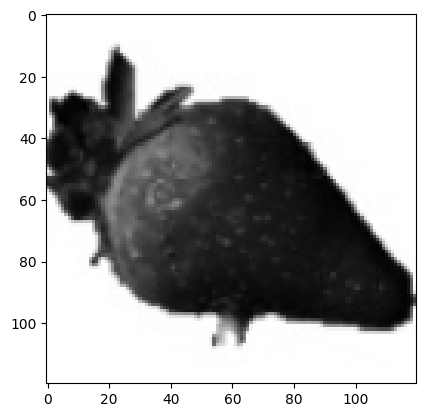

In [13]:
plt.imshow(x[5000], cmap='gray')

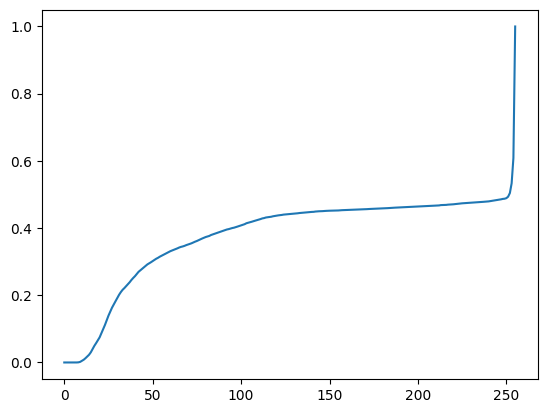

In [14]:
plt.plot(y[5000])

In [15]:
#compiling model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [16]:
history = model.fit(x,y, epochs=100)

Epoch 1/100
216/216 [==============================] - 21s 14ms/step - loss: 0.0285 - accuracy: 0.1102
Epoch 2/100
216/216 [==============================] - 3s 13ms/step - loss: 0.0055 - accuracy: 0.2287
Epoch 3/100
216/216 [==============================] - 3s 14ms/step - loss: 0.0043 - accuracy: 0.2779
Epoch 4/100
216/216 [==============================] - 3s 14ms/step - loss: 0.0037 - accuracy: 0.3118
Epoch 5/100
216/216 [==============================] - 3s 14ms/step - loss: 0.0036 - accuracy: 0.3218
Epoch 6/100
216/216 [==============================] - 3s 14ms/step - loss: 0.0027 - accuracy: 0.3286
Epoch 7/100
216/216 [==============================] - 3s 14ms/step - loss: 0.0028 - accuracy: 0.3324
Epoch 8/100
216/216 [==============================] - 3s 14ms/step - loss: 0.0029 - accuracy: 0.3360
Epoch 9/100
216/216 [==============================] - 3s 14ms/step - loss: 0.0026 - accuracy: 0.3380
Epoch 10/100
216/216 [==============================] - 3s 14ms/step - loss: 0.00

Epoch 79/100
216/216 [==============================] - 3s 14ms/step - loss: 5.1874e-04 - accuracy: 0.3435
Epoch 80/100
216/216 [==============================] - 3s 14ms/step - loss: 4.6643e-04 - accuracy: 0.3431
Epoch 81/100
216/216 [==============================] - 3s 14ms/step - loss: 5.3456e-04 - accuracy: 0.3437
Epoch 82/100
216/216 [==============================] - 3s 14ms/step - loss: 4.5284e-04 - accuracy: 0.3428
Epoch 83/100
216/216 [==============================] - 3s 15ms/step - loss: 4.9332e-04 - accuracy: 0.3341
Epoch 84/100
216/216 [==============================] - 3s 15ms/step - loss: 4.8143e-04 - accuracy: 0.3412
Epoch 85/100
216/216 [==============================] - 3s 15ms/step - loss: 4.3140e-04 - accuracy: 0.3440
Epoch 86/100
216/216 [==============================] - 3s 15ms/step - loss: 4.4949e-04 - accuracy: 0.3437
Epoch 87/100
216/216 [==============================] - 3s 15ms/step - loss: 4.7542e-04 - accuracy: 0.3354
Epoch 88/100
216/216 [===============

In [20]:
img = cv2.imread('natural_images/dog_0001.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img,(120,120))
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img,axis=3)
pred = model.predict(img)[0]
pred = post_process(pred)

In [18]:
img.shape

(1, 120, 120, 1)

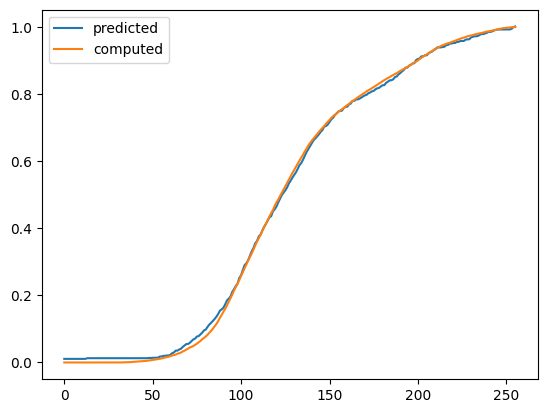

In [23]:
plt.plot(pred, label = 'predicted')
plt.plot(calc_cdf(img), label = 'computed')
plt.legend()

In [19]:
pred = post_process(pred)

In [20]:
pred.max()

1.0054699

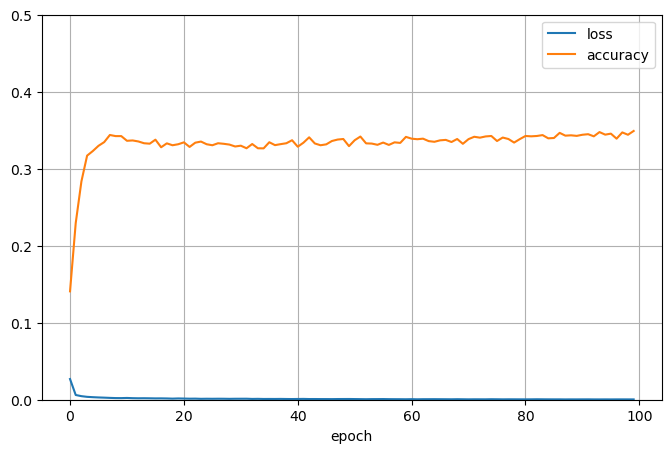

In [17]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel('epoch')
plt.grid(True)
plt.gca().set_ylim(0,0.5)
plt.show()